In [7]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter, savgol_coeffs
from scipy.optimize import curve_fit

import math

import json

## General Tool Functions

In [8]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)

In [9]:
def calculate_slope_integral(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_slope_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=1
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=1, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_prime = D @ I
    I_prime_sq = I_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def calculate_curvature_integral(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I
    
    # Use Savitzky-Golay filter to get the second derivative of intensity with respect to Q
    smoothed_I_double_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=2, delta=np.mean(np.diff(Q_best)))
    
    # Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_curvature_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=2
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=2, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_double_prime = D @ I
    I_double_prime_sq = I_double_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_double_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_double_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def f_beta(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the beta parameter 
    """
    beta = calculate_slope_integral(data, window_length, polyorder) / (12.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_slope_integral_with_uncertainty(data, window_length, polyorder)
        beta, beta_std = integral / (12.0 * (data.Q.max() - data.Q.min())), integral_std / (12.0 * (data.Q.max() - data.Q.min()))
        return beta, beta_std
    return beta

def f_gamma(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the gamma parameter 
    """
    gamma = calculate_curvature_integral(data, window_length, polyorder) / (4.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_curvature_integral_with_uncertainty(data, window_length, polyorder)
        gamma, gamma_std = integral / (4.0 * (data.Q.max() - data.Q.min())), integral_std / (4.0 * (data.Q.max() - data.Q.min()))
        return gamma, gamma_std
    return gamma

def f_alpha(data, total_counts):
    """
    Calculate the A0 parameter 
    """
    L = data.Q.max() - data.Q.min()
    mean_I = np.mean(data.I)
    return L * (mean_I ** 2)/ total_counts

In [56]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor < 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5, polyorder=3, log_I=False, log_Q=False):
    Q_best = best_data.Q
    I_best = best_data.I
    if log_I:
        I_best = np.log(I_best)
    if log_Q:
        Q_best = np.log(Q_best)
        Q_query = np.log(Q_query)
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = polyorder
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    I_query = interp_func(Q_query)
    if log_I:
        I_query = np.exp(I_query)
    return I_query

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None, var=False, var_y=False):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Build Kff (latent kernel)
    if D2 is None:
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2
        Kff = s2 * np.exp(-0.5 * D2)
    else:
        Kff = s2 * np.exp(-0.5 * D2 / (length * length))

    # Noise vector (nv) unified
    if np.isscalar(noise_var):
        nv = float(noise_var)
        nv_vec = None
    else:
        nv_vec = np.ascontiguousarray(noise_var, dtype=y.dtype)

    # Ky = Kff + Sigma + jitter I
    Ky = Kff.copy()
    if nv_vec is None:
        Ky.ravel()[::n+1] += (nv + jitter)
    else:
        Ky.ravel()[::n+1] += (nv_vec + jitter)

    L = np.linalg.cholesky(Ky)

    # alpha = Ky^{-1} y via Cholesky
    alpha = np.linalg.solve(L, y)
    alpha = np.linalg.solve(L.T, alpha)

    # Posterior mean at training points: mu = Kff * alpha = y - Sigma * alpha
    if nv_vec is None:
        mu = y - nv * alpha
    else:
        mu = y - nv_vec * alpha

    if not var:
        return mu

    # Posterior variance of latent f at training points:
    # diag(Kff - Kff Ky^{-1} Kff) = diag(Kff) - sum((L^{-1} Kff)^2, axis=0)
    V = np.linalg.solve(L, Kff)               # V = L^{-1} Kff
    var_f = np.diag(Kff) - np.sum(V * V, axis=0)

    # Numerical safety
    var_f = np.maximum(var_f, 0.0)

    if var_y:
        # predictive variance for noisy observations at training points
        if nv_vec is None:
            return mu, var_f + nv
        else:
            return mu, var_f + nv_vec

    return mu, var_f

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

# yyw

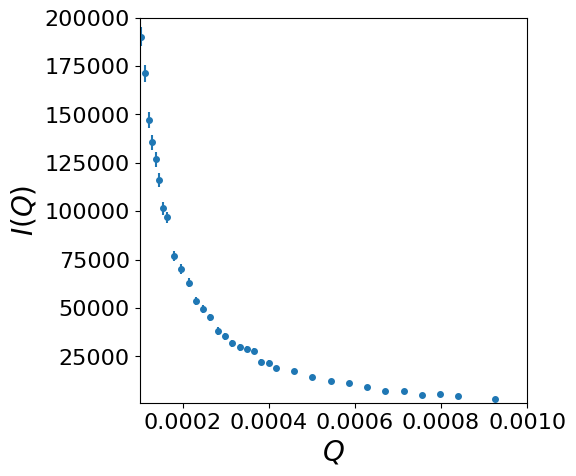

In [11]:
filename_eq = "./desmearing/data/yyw_SANS_USANS_data/s0_combined_iso.dat"
data_eq = np.loadtxt(filename_eq)
Q_eq = data_eq[:, 0]
I_eq = data_eq[:, 1]
delta_I_eq = data_eq[:, 2]
delta_Q_eq = data_eq[:, 3]
bg_eq = 0.297
# I_eq -= bg_eq

filename_USANS_para = "./desmearing/data/yyw_SANS_USANS_data/sample0_para_8mm.txt"
data_USANS_para = np.loadtxt(filename_USANS_para, delimiter=',', dtype=float, usecols=(0, 1, 2))
Q_usans_para = data_USANS_para[:, 0]
I_usans_para = data_USANS_para[:, 1]
delta_I_usans_para = data_USANS_para[:, 2]

filename_USANS_perp = "./desmearing/data/yyw_SANS_USANS_data/sample0_perp_8mm.txt"
data_USANS_perp = np.loadtxt(filename_USANS_perp, delimiter=',', dtype=float, usecols=(0, 1, 2))
Q_usans_perp = data_USANS_perp[:, 0]
I_usans_perp = data_USANS_perp[:, 1]
delta_I_usans_perp = data_USANS_perp[:, 2]

# assume the isotropic SANS data can be estimated as the average of the two USANS directions
Q_obs = Q_usans_para
I_obs = 0.5 * (I_usans_para + I_usans_perp)
delta_I_obs = 0.5 * (delta_I_usans_para + delta_I_usans_perp)

best_data = type('Data', (object,), {})()  # create a simple object to hold the data
best_data.Q = Q_obs
best_data.I = I_obs
best_data.I_err = delta_I_obs

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(Q_obs, I_obs, yerr=delta_I_obs, fmt='o', label='Observed USANS', markersize=4)

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-4, 1e-3)
ax.set_ylim(1e3, 2e5)
# ax.set_ylim(1e-3, 1e2)
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
bin width: 8.67313486892712e-06


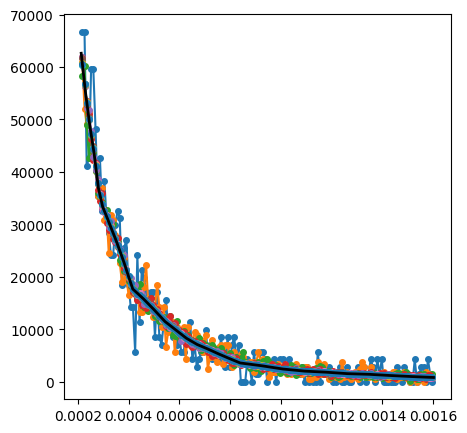

In [12]:
# select the Q range of interest
Q_min_range = 2e-4
Q_max_range = 2e-3

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], np.diff(best_data.Q)[0]*np.ones(np.sum(Q_mask)))  # assume uniform dQ for simplicity

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 8
polyorder = 2

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'none'
    collimation = 'none'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 160
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'none' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
ax.set_xscale('linear')
ax.set_yscale('linear')
print("bin width:", bin_width)


In [13]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []

for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['none']['none'][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 4.4745e+05
beta  = 1.3939e+14 ± 4.3736e+12
gamma = 7.5031e+22 ± 3.9263e+21
h_instr = 8.6189e-06
time = 1000.0, h_FD = 1.1708e-04, lambda_opt = 5.3060e-05
time = 3000.0, h_FD = 8.1181e-05, lambda_opt = 4.2594e-05
time = 10000.0, h_FD = 5.4346e-05, lambda_opt = 3.3479e-05
time = 30000.0, h_FD = 3.7681e-05, lambda_opt = 2.6875e-05
time = 100000.0, h_FD = 2.5225e-05, lambda_opt = 2.1124e-05
time = 300000.0, h_FD = 1.7490e-05, lambda_opt = 1.6957e-05
time = 1000000.0, h_FD = 1.1708e-05, lambda_opt = 1.3328e-05
time = 3000000.0, h_FD = 8.1181e-06, lambda_opt = 1.0699e-05
time = 10000000.0, h_FD = 5.4346e-06, lambda_opt = 8.4095e-06
time = 30000000.0, h_FD = 3.7681e-06, lambda_opt = 6.7506e-06
time = 100000000.0, h_FD = 2.5225e-06, lambda_opt = 5.3060e-06


/tmp/ipykernel_2112706/1626038288.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


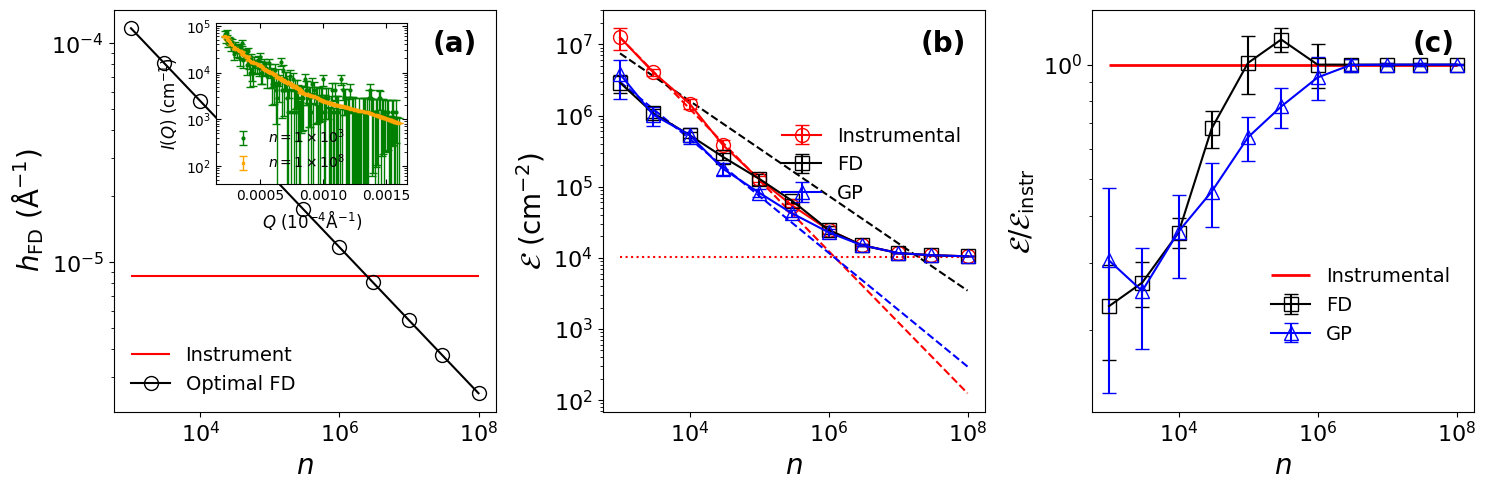

In [8]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['none']['none'][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['none']['none'][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)
ax.plot(count_list, pre_factor*count_list**(-2/3), '--', color='k', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
# output_data = {
#     "count_list": count_list.tolist(),
#     "synthetic_data_list": [
#         {
#             bin_size: {
#                 collimation: {
#                     str(time): {
#                         "Q": sd.Q.tolist(),
#                         "I": sd.I.tolist(),
#                         "I_err": sd.I_err.tolist(),
#                         "dQ": sd.dQ.tolist(),
#                         "total_counts": sd.total_counts
#                     }
#                     for time, sd in collimation_data.items()
#                 }
#                 for collimation, collimation_data in bin_data.items()
#             }
#             for bin_size, bin_data in synthetic_data.items()
#         }
#         for synthetic_data in synthetic_data_list
#     ],
#     "mise_instr_stat": mise_instr_stat.tolist(),
#     "mise_FD_stat": mise_FD_stat.tolist(),
#     "mise_GP_stat": mise_GP_stat.tolist(),
#     "A0_best": A0_best,
#     "beta_best": beta_best,
#     "beta_best_std": beta_best_std,
#     "gamma_best": gamma_best,
#     "gamma_best_std": gamma_best_std,
#     "pre_factor": pre_factor,
#     "h_FD_list": h_FD_list,
#     "lambda_opt_list": lambda_opt_list
# }

# # Save to JSON file
# output_file = "analysis_yyw.json"
# with open(output_file, "w") as f:
#     json.dump(output_data, f, indent=4)

# print(f"Data successfully stored in {output_file}")

# tz

Text(0, 0.5, 'I(Q) (cm$^{-1}$)')

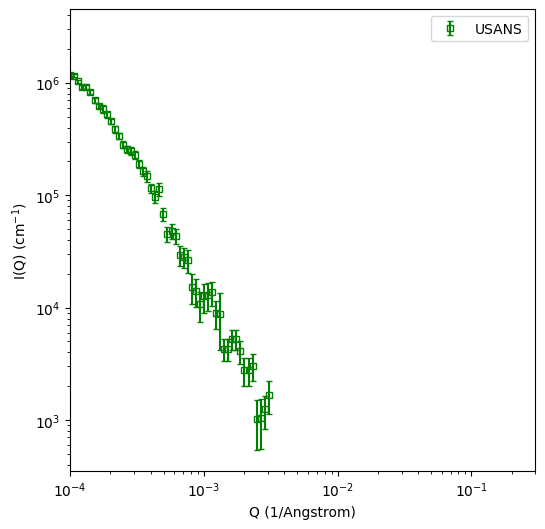

In [9]:
index = "4048"


filename_USANS = f"./desmearing/data/tz_SANS_USANS_data/data/UN_X{index}_det_1_lbs.txt"
data_USANS = np.loadtxt(filename_USANS, delimiter='\t', dtype=float, usecols=(0, 1, 2))
Q_usans = data_USANS[:, 0]
I_usans = data_USANS[:, 1]
delta_I_usans = data_USANS[:, 2]

best_data = type('Data', (object,), {})()  # create a simple object to hold the data
best_data.Q = Q_usans
best_data.I = I_usans
best_data.I_err = delta_I_usans

# plot the data to verify loading
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans, fmt='s', markersize=4, label='USANS', fillstyle='none', capsize=2, color='green')
ax.legend()
ax.set_xlim(1e-4, 3e-1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (1/Angstrom)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')

Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
bin width: 1.045560625e-05


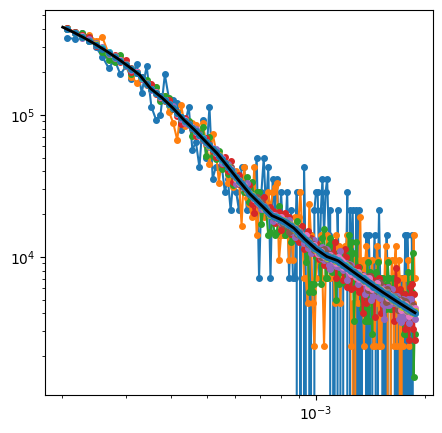

In [10]:
# select the Q range of interest
Q_min_range = 2e-4
Q_max_range = 2e-3

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], np.diff(best_data.Q)[0]*np.ones(np.sum(Q_mask)))  # assume uniform dQ for simplicity

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 16
polyorder = 2

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'none'
    collimation = 'none'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 160
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'none' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
# ax.set_xscale('linear')
# ax.set_yscale('linear')
print("bin width:", bin_width)


In [11]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['none']['none'][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 1.8058e+07
beta  = 2.1788e+15 ± 5.0400e+13
gamma = 2.0906e+23 ± 6.8406e+21
h_instr = 1.0390e-05
time = 1000.0, h_FD = 1.6062e-04, lambda_opt = 9.0562e-05
time = 3000.0, h_FD = 1.1137e-04, lambda_opt = 7.2698e-05
time = 10000.0, h_FD = 7.4554e-05, lambda_opt = 5.7141e-05
time = 30000.0, h_FD = 5.1693e-05, lambda_opt = 4.5869e-05
time = 100000.0, h_FD = 3.4605e-05, lambda_opt = 3.6053e-05
time = 300000.0, h_FD = 2.3994e-05, lambda_opt = 2.8941e-05
time = 1000000.0, h_FD = 1.6062e-05, lambda_opt = 2.2748e-05
time = 3000000.0, h_FD = 1.1137e-05, lambda_opt = 1.8261e-05
time = 10000000.0, h_FD = 7.4554e-06, lambda_opt = 1.4353e-05
time = 30000000.0, h_FD = 5.1693e-06, lambda_opt = 1.1522e-05
time = 100000000.0, h_FD = 3.4605e-06, lambda_opt = 9.0562e-06


/tmp/ipykernel_2112706/3967318872.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


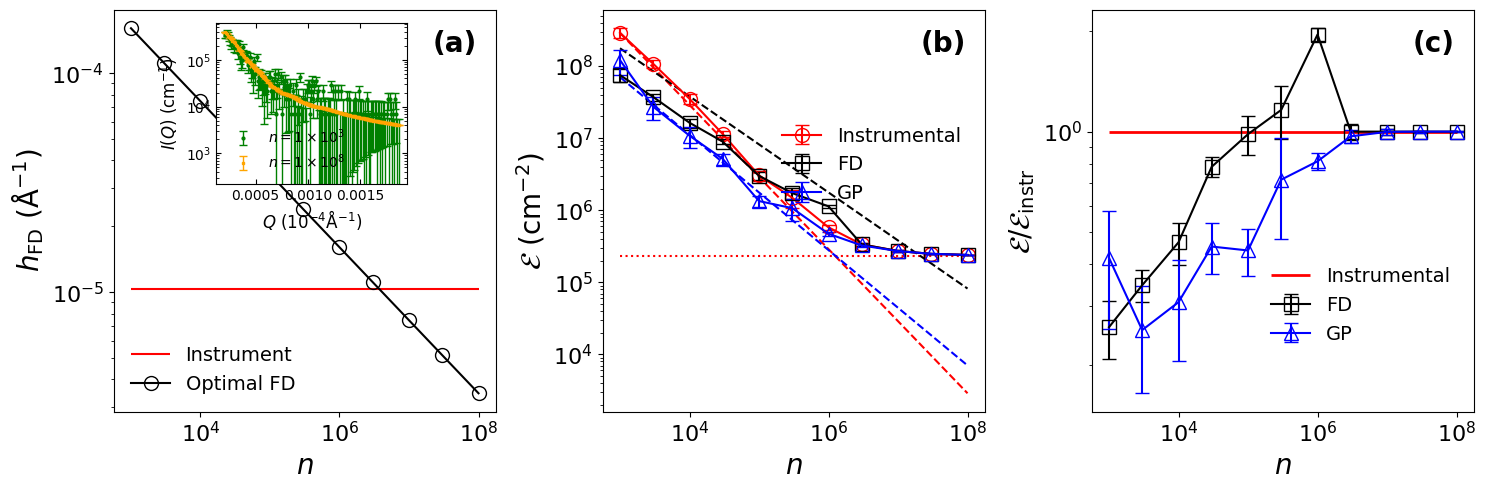

In [12]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['none']['none'][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['none']['none'][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)
ax.plot(count_list, pre_factor*count_list**(-2/3), '--', color='k', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
# output_data = {
#     "count_list": count_list.tolist(),
#     "synthetic_data_list": [
#         {
#             bin_size: {
#                 collimation: {
#                     str(time): {
#                         "Q": sd.Q.tolist(),
#                         "I": sd.I.tolist(),
#                         "I_err": sd.I_err.tolist(),
#                         "dQ": sd.dQ.tolist(),
#                         "total_counts": sd.total_counts
#                     }
#                     for time, sd in collimation_data.items()
#                 }
#                 for collimation, collimation_data in bin_data.items()
#             }
#             for bin_size, bin_data in synthetic_data.items()
#         }
#         for synthetic_data in synthetic_data_list
#     ],
#     "mise_instr_stat": mise_instr_stat.tolist(),
#     "mise_FD_stat": mise_FD_stat.tolist(),
#     "mise_GP_stat": mise_GP_stat.tolist(),
#     "A0_best": A0_best,
#     "beta_best": beta_best,
#     "beta_best_std": beta_best_std,
#     "gamma_best": gamma_best,
#     "gamma_best_std": gamma_best_std,
#     "pre_factor": pre_factor,
#     "h_FD_list": h_FD_list,
#     "lambda_opt_list": lambda_opt_list
# }

# # Save to JSON file
# output_file = "analysis_tz.json"
# with open(output_file, "w") as f:
#     json.dump(output_data, f, indent=4)

# print(f"Data successfully stored in {output_file}")

# ss

Text(0, 0.5, 'I(Q) (cm$^{-1}$)')

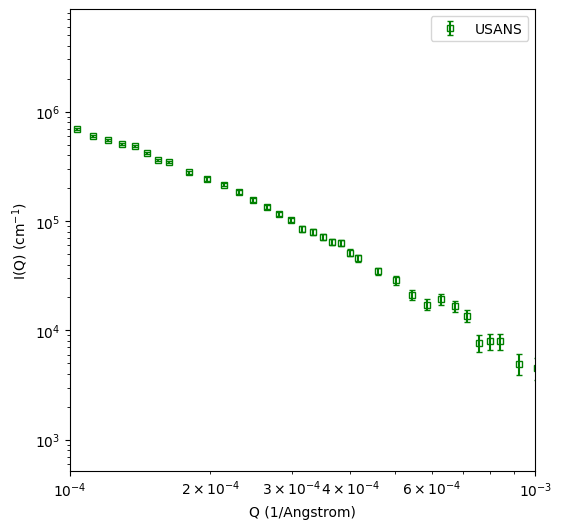

In [13]:
# filename_USANS = f"./data/ss_SANS_USANS_data/UN_Dup2_R2_Top3_1.7_sat_det_1.txt"
filename_USANS = f"./desmearing/data/ss_SANS_USANS_data/UN_Dup2_R4_Top3_1c_unsat_det_1.txt"
data_USANS = np.loadtxt(filename_USANS, delimiter=',', dtype=float, usecols=(0, 1, 2))
Q_usans = data_USANS[:, 0]
I_usans = data_USANS[:, 1]
delta_I_usans = data_USANS[:, 2]

best_data = type('Data', (object,), {})()  # create a simple object to hold the data
best_data.Q = Q_usans
best_data.I = I_usans
best_data.I_err = delta_I_usans

# plot the data to verify loading
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(Q_usans, I_usans, yerr=delta_I_usans, fmt='s', markersize=4, label='USANS', fillstyle='none', capsize=2, color='green')
ax.legend()
ax.set_xlim(1e-4, 1e-3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (1/Angstrom)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')

Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
Using nbins = 160 for synthetic data generation
bin width: 5.129841965158112e-06


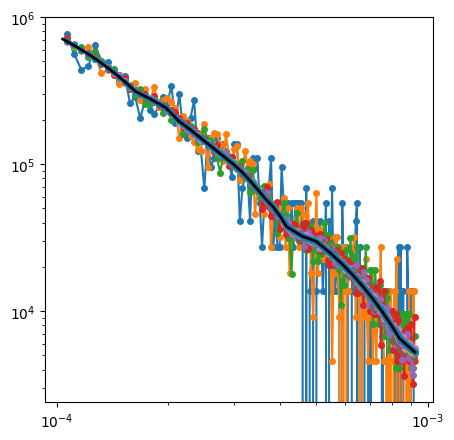

In [14]:
# select the Q range of interest
Q_min_range = 1e-4
Q_max_range = 1e-3

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], np.diff(best_data.Q)[0]*np.ones(np.sum(Q_mask)))  # assume uniform dQ for simplicity

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)
window_length = 20
polyorder = 2

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

# count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6]  # total counts for synthetic data
count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8]  # total counts for synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 4
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'none'
    collimation = 'none'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    # nbins = int(len(sd_ref.Q)*4)
    nbins = 160
    print(f"Using nbins = {nbins} for synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'none' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
# ax.set_xscale('linear')
# ax.set_yscale('linear')
print("bin width:", bin_width)


In [15]:
# evaluate parameters from best data
beta_best, beta_best_std = f_beta(best_data, window_length=window_length, polyorder=polyorder, std=True)
gamma_best, gamma_best_std = f_gamma(best_data, window_length=window_length, polyorder=polyorder, std=True)
A0_best = f_alpha(best_data, 1)
h_instr = (sd_syn.Q.max() - sd_syn.Q.min()) / len(sd_syn.Q)  # instrumental bin width

# best data interpolation function
f_best = lambda Q_query: interpolate_best_I(best_data, Q_query, window_length=window_length, polyorder=polyorder, log_I=True, log_Q=True)

print('alpha*n = {:.4e}'.format(A0_best))
print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
print('h_instr = {:.4e}'.format(h_instr))

mise_instr_stat = []
mise_FD_stat = []
mise_GP_stat = []
h_FD_list = []
lambda_opt_list = []
for i_time, time_str in enumerate(count_list):
    alpha = f_alpha(best_data, float(time_str))
    h_FD = (alpha / (2 * beta_best))**(1/3)
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    print('time = {}, h_FD = {:.4e}, lambda_opt = {:.4e}'.format(time_str, h_FD, lambda_opt))
    h_FD_list.append(h_FD)
    lambda_opt_list.append(lambda_opt)
    
    rebin_factor = max(1, int(round(h_FD/h_instr)))
    
    mise_instr_current = []
    mise_FD_current = []
    mise_GP_current = []
    for i_MC in range(N_MC):
        synthetic_data = synthetic_data_list[i_MC]
        sd_syn = synthetic_data['none']['none'][time_str]

        # calculate mise components
        ## instrumental pixel size
        I_ref = f_best(sd_syn.Q)
        mise_instr_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_instr_1_theory = alpha*G_of_rho(1e4)/h_instr
        mise_instr_1_sampled = np.mean((sd_syn.I - I_ref)**2)
        mise_instr_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_instr_3 = gamma_best * h_instr**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_instr = mise_instr_1_sampled + mise_instr_2 + mise_instr_3 
        mise_instr_theory = mise_instr_1_theory + mise_instr_2 + mise_instr_3
        mise_instr_current.append([mise_instr_1, mise_instr_1_sampled, mise_instr_2, mise_instr_3, mise_instr, mise_instr_1_theory, mise_instr_2, mise_instr_3, mise_instr_theory])
        
        ## optimal FD rebinning
        sd_syn_rebinned = rebin_data(sd_syn, rebin_factor=rebin_factor)
        I_ref_rebinned = f_best(sd_syn_rebinned.Q)
        h_rebinned = (sd_syn_rebinned.Q.max() - sd_syn_rebinned.Q.min()) / len(sd_syn_rebinned.Q)
        mise_FD_1 = np.trapz((sd_syn_rebinned.I_err)**2, sd_syn_rebinned.Q, dx=h_rebinned)/np.trapz(np.ones_like(sd_syn_rebinned.Q), sd_syn_rebinned.Q, dx=h_rebinned) # counting error (estimated from I_err)
        mise_FD_1_theory = alpha*G_of_rho(1e4)/h_FD
        mise_FD_1_sampled = np.mean((sd_syn_rebinned.I - I_ref_rebinned)**2)
        mise_FD_2 = beta_best * h_rebinned**2  # binning distortion (using beta from best data)
        mise_FD_2_theory = beta_best * h_FD**2
        mise_FD_3 = gamma_best * h_rebinned**4 * 0 # curvature distortion (using gamma from best data, 0 for no GP result)
        mise_FD_3_theory = gamma_best * h_FD**4 * 0
        mise_FD = mise_FD_1_sampled + mise_FD_2 + mise_FD_3
        mise_FD_theory = mise_FD_1_theory + mise_FD_2_theory + mise_FD_3_theory
        mise_FD_current.append([mise_FD_1, mise_FD_1_sampled, mise_FD_2, mise_FD_3, mise_FD, mise_FD_1_theory, mise_FD_2_theory, mise_FD_3_theory, mise_FD_theory])
        
        ## improved via GP, using instrumental bin size
        mu_gpr = gpr_posterior_mean(sd_syn.Q, sd_syn.I, (sd_syn.I_err)**2, length=lambda_opt, s2=float(np.var(sd_syn.I)) if np.isfinite(sd_syn.I).all() else 1.0, jitter=1e-10)
        I_ref = f_best(sd_syn.Q)
        rho = lambda_opt/h_instr
        mise_GP_1 = np.trapz((sd_syn.I_err)**2, sd_syn.Q, dx=h_instr)/np.trapz(np.ones_like(sd_syn.Q), sd_syn.Q, dx=h_instr) # counting error (estimated from I_err)
        mise_GP_1_theory = alpha*G_of_rho(rho)/h_instr
        mise_GP_1_sampled = np.mean((mu_gpr - I_ref)**2)
        mise_GP_2 = beta_best * h_instr**2  # binning distortion (using beta from best data)
        mise_GP_3 = gamma_best * h_instr**4 * (mu2_of_rho(rho, h_instr))**2 # curvature distortion (using gamma from best data)
        mise_GP = mise_GP_1_sampled + mise_GP_2 + mise_GP_3 
        mise_GP_theory = mise_GP_1_theory + mise_GP_2 + mise_GP_3
        mise_GP_current.append([mise_GP_1, mise_GP_1_sampled, mise_GP_2, mise_GP_3, mise_GP, mise_GP_1_theory, mise_GP_2, mise_GP_3, mise_GP_theory])
        
    mise_instr_stat.append([np.mean(mise_instr_current, axis=0), np.std(mise_instr_current, axis=0)])
    mise_FD_stat.append([np.mean(mise_FD_current, axis=0), np.std(mise_FD_current, axis=0)])
    mise_GP_stat.append([np.mean(mise_GP_current, axis=0), np.std(mise_GP_current, axis=0)])
    
mise_instr_stat = np.array(mise_instr_stat)
mise_FD_stat = np.array(mise_FD_stat)
mise_GP_stat = np.array(mise_GP_stat)

alpha*n = 2.5747e+07
beta  = 2.0363e+16 ± 1.3887e+14
gamma = 5.9626e+24 ± 5.0832e+22
h_instr = 5.0978e-06
time = 1000.0, h_FD = 8.5825e-05, lambda_opt = 4.9742e-05
time = 3000.0, h_FD = 5.9508e-05, lambda_opt = 3.9930e-05
time = 10000.0, h_FD = 3.9836e-05, lambda_opt = 3.1385e-05
time = 30000.0, h_FD = 2.7621e-05, lambda_opt = 2.5194e-05
time = 100000.0, h_FD = 1.8490e-05, lambda_opt = 1.9803e-05
time = 300000.0, h_FD = 1.2821e-05, lambda_opt = 1.5896e-05
time = 1000000.0, h_FD = 8.5825e-06, lambda_opt = 1.2495e-05
time = 3000000.0, h_FD = 5.9508e-06, lambda_opt = 1.0030e-05
time = 10000000.0, h_FD = 3.9836e-06, lambda_opt = 7.8836e-06
time = 30000000.0, h_FD = 2.7621e-06, lambda_opt = 6.3285e-06
time = 100000000.0, h_FD = 1.8490e-06, lambda_opt = 4.9742e-06


/tmp/ipykernel_2112706/1718877808.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


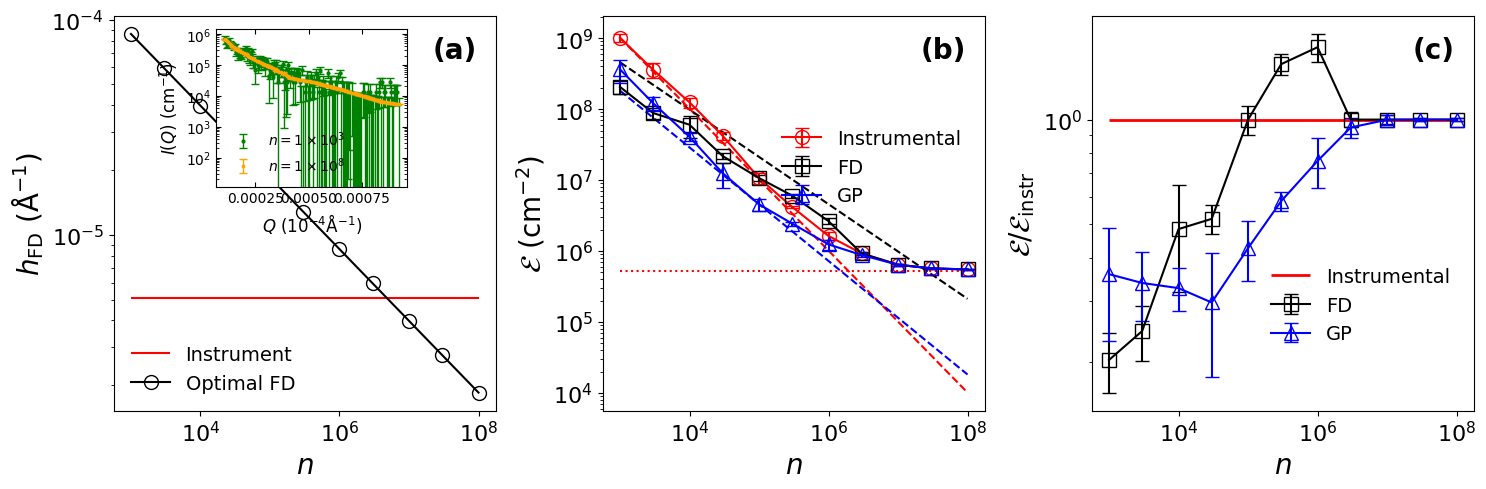

In [16]:
count_list = np.array(count_list)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
ax.hlines(h_instr, xmin=count_list[0], xmax=count_list[-1], label='Instrument', colors='r', linestyles='-')
ax.plot(count_list, h_FD_list, 'o-', label='Optimal FD', color='k', markersize=10, fillstyle='none')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}\ (\mathrm{\AA}^{-1})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc='lower left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5, 1e-2)

sd_syn_short_time = synthetic_data_list[0]['none']['none'][count_list[0]]
sd_syn_long_time = synthetic_data_list[0]['none']['none'][count_list[-1]]
inset_ax = inset_axes(ax, width="50%", height="40%", loc='lower left', bbox_to_anchor=(0.25, 0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(sd_syn_short_time.Q, sd_syn_short_time.I, yerr=sd_syn_short_time.I_err, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', fmt='o', markersize=2, elinewidth=1, color='green', capsize=3)
inset_ax.errorbar(sd_syn_long_time.Q, sd_syn_long_time.I, yerr=sd_syn_long_time.I_err, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', fmt='s', markersize=2, elinewidth=1, color='orange', capsize=3)
inset_ax.set_yscale('log')
# inset_ax.set_xlim(2e-3, 2e-2)
# inset_ax.set_ylim(1e-1, 1e2)
# inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
# inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax.text(0.95, 0.95, "(a)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(132)

i_component = 4  # total MISE
i_component_theory = 8
ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
            label='Instrumental', fmt='o-', capsize=5, markersize=10, fillstyle='none', color='r')
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, markersize=10, fillstyle='none', color='k')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, markersize=10, fillstyle='none', color='b')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')

ax.plot(count_list, mise_instr_stat[0][0][i_component]*count_list[0]/count_list, '--', color='r', zorder=-20)
ax.plot(count_list, [mise_instr_stat[i][0][2] +mise_instr_stat[i][0][3] for i in range(len(count_list))], ':', color='r', zorder=-20)

# ax.plot(count_list, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), '--', color='b', zorder=-20)
# ax.fill_between(count_list, np.ones_like(count_list)*1e-5, mise_GP_stat[0][0][i_component]*(count_list[0]/count_list)**(4/5), color='b', alpha=0.1, zorder=-21)
pre_factor = (5/4) * (2*np.pi)**(-2/5) * (A0_best**(4/5)) * (gamma_best**(1/5)) 
ax.plot(count_list, pre_factor*count_list**(-4/5), '--', color='b', zorder=-20)
ax.plot(count_list, pre_factor*count_list**(-2/3), '--', color='k', zorder=-20)

# ax.set_ylim(1e3, 1e6)

ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}\ (\mathrm{cm}^{-2})$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.text(0.95, 0.95, "(b)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')


ax = fig.add_subplot(133)
# ax.errorbar(count_list, [mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
#             yerr=[mise_instr_stat[i][1][i_component] for i in range(len(count_list))],
#             label='Instrumental', fmt='o-', capsize=5)
ax.hlines(1.0, xmin=count_list[0], xmax=count_list[-1], label='Instrumental', colors='r', linestyles='-', linewidth=2)
ax.errorbar(count_list, [mise_FD_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_FD_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='FD', fmt='s-', capsize=5, color='k', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_FD_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='Instrumental Binning (theory)', linestyle=':', color='C1')
ax.errorbar(count_list, [mise_GP_stat[i][0][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            yerr=[mise_GP_stat[i][1][i_component]/mise_instr_stat[i][0][i_component] for i in range(len(count_list))],
            label='GP', fmt='^-', capsize=5, color='b', markersize=10, fillstyle='none')
# ax.plot(count_list, [mise_GP_stat[i][0][i_component_theory] for i in range(len(count_list))],
#             label='GPR Smoothing (theory)', linestyle=':', color='C2')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\mathcal{E}/\mathcal{E}_\mathrm{instr}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=14, frameon=False, loc=(0.45, 0.15))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(0.1, 2)
ax.text(0.95, 0.95, "(c)", transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')

plt.tight_layout()

# store plotting outputs and metadata in json format
# Prepare data to store in JSON format
# output_data = {
#     "count_list": count_list.tolist(),
#     "synthetic_data_list": [
#         {
#             bin_size: {
#                 collimation: {
#                     str(time): {
#                         "Q": sd.Q.tolist(),
#                         "I": sd.I.tolist(),
#                         "I_err": sd.I_err.tolist(),
#                         "dQ": sd.dQ.tolist(),
#                         "total_counts": sd.total_counts
#                     }
#                     for time, sd in collimation_data.items()
#                 }
#                 for collimation, collimation_data in bin_data.items()
#             }
#             for bin_size, bin_data in synthetic_data.items()
#         }
#         for synthetic_data in synthetic_data_list
#     ],
#     "mise_instr_stat": mise_instr_stat.tolist(),
#     "mise_FD_stat": mise_FD_stat.tolist(),
#     "mise_GP_stat": mise_GP_stat.tolist(),
#     "A0_best": A0_best,
#     "beta_best": beta_best,
#     "beta_best_std": beta_best_std,
#     "gamma_best": gamma_best,
#     "gamma_best_std": gamma_best_std,
#     "pre_factor": pre_factor,
#     "h_FD_list": h_FD_list,
#     "lambda_opt_list": lambda_opt_list
# }

# # Save to JSON file
# output_file = "analysis_ss.json"
# with open(output_file, "w") as f:
#     json.dump(output_data, f, indent=4)

# print(f"Data successfully stored in {output_file}")

# strategy under different flux and shape

Results from analysis_yyw.json:
alpha*n = 1.6000e+05
beta  = 5.5807e+13 ± 2.1633e+12
gamma = 1.3579e+22 ± 9.7847e+20
pre_factor = 2.3308e+08
n_cross = 1000000.0, E_cross = 3561.160360678626
Results from analysis_tz.json:
alpha*n = 4.6136e+06
beta  = 5.4069e+14 ± 1.8914e+13
gamma = 5.2935e+22 ± 2.1872e+21
pre_factor = 4.5042e+09
n_cross = 3000000.0, E_cross = 51309.195723332734
Results from analysis_ss.json:
alpha*n = 2.9492e+06
beta  = 1.8744e+15 ± 2.3577e+13
gamma = 3.7013e+23 ± 6.0156e+21
pre_factor = 4.6459e+09
n_cross = 10000000.0, E_cross = 36529.65727093233
Results from ./binning/analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
n_cross = 10000000.0, E_cross = 34.313640497185446
Results from analysis_yyw.json:
alpha*n = 1.6000e+05
beta  = 5.5807e+13 ± 2.1633e+12
gamma = 1.3579e+22 ± 9.7847e+20
pre_factor = 2.3308e+08
Results from analysis_tz.json:
alpha*n = 4.6136e+06
beta  = 5.4069e+14 ± 1.8914e

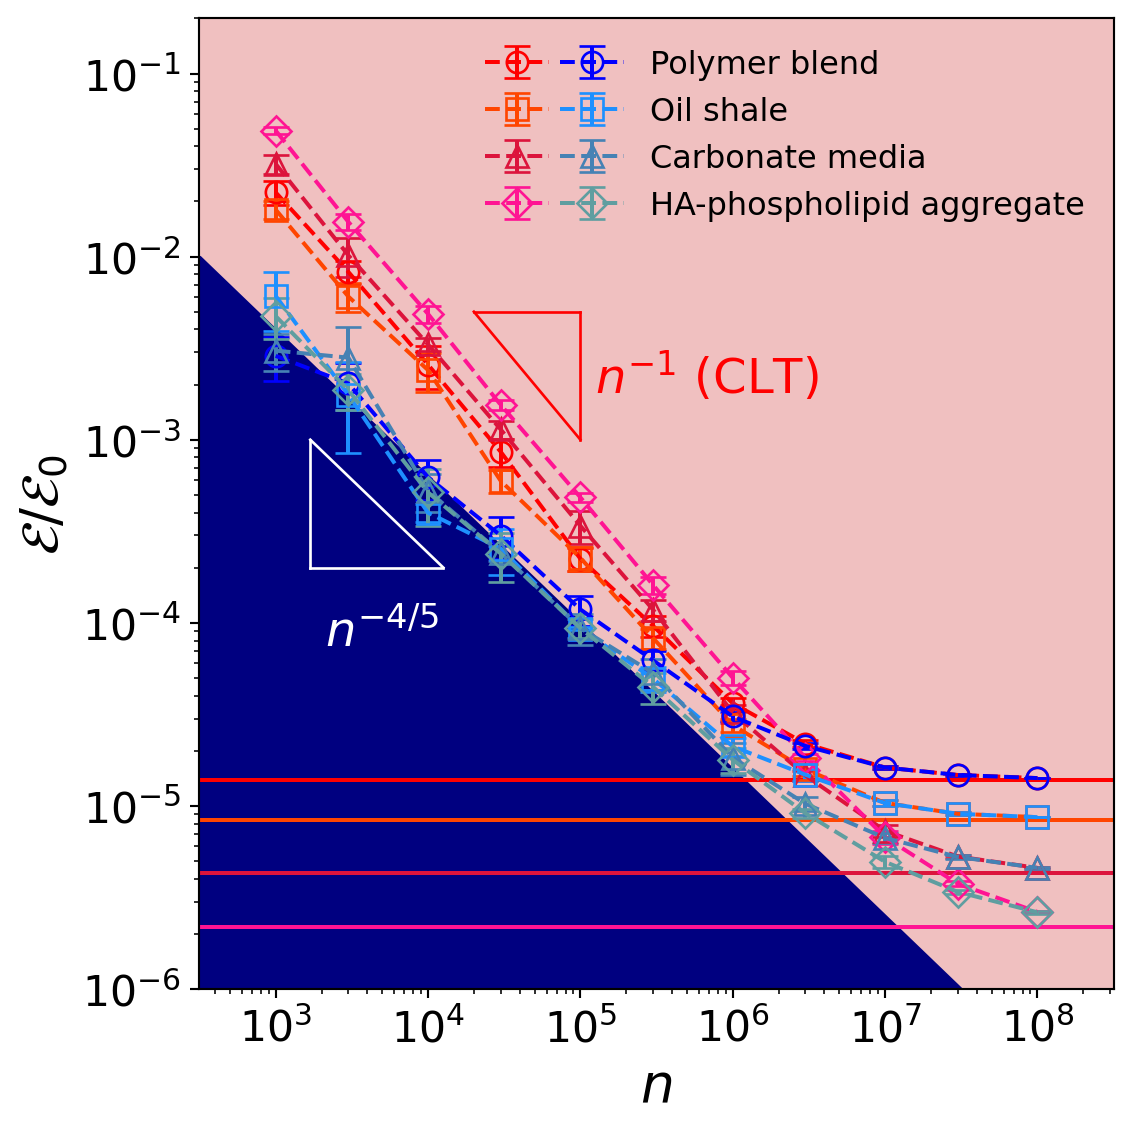

In [160]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
import json
from collections import defaultdict
from scipy.optimize import curve_fit

filename_json_list = ["analysis_yyw.json", "analysis_tz.json", "analysis_ss.json", './binning/analysis_USANS28523.json']
label_list = ["Polymer blend", "Oil shale", "Carbonate media", "HA-phospholipid aggregate"]
fig = plt.figure(figsize=(6, 6), dpi=192)
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#DC143C', '#FF1493', '#B22222', '#FF6347', '#FF7F50', '#FF8C00']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1
ax1.set_facecolor('#F0C0C0')

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    h_FD_list = np.array(loaded_data["h_FD_list"])
    lambda_opt_list = np.array(loaded_data["lambda_opt_list"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    # Calculate the intersection point
    E_cross = (mise_GP_stat[:, 0, 2] + mise_GP_stat[:, 0, 3])
    n_cross = count_list[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]
    print(f"n_cross = {n_cross}, E_cross = {E_cross[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]}")
    
    ax1.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor, yerr=mise_instr_stat[:,1,4]/pre_factor, fmt='--', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx], label=' ')
    # ax1.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor, yerr=mise_GP_stat[:,1,4]/pre_factor, linestyle='-', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])
    # ax1.plot(count_list, count_list**(-4/5), '--', label=filename_json.replace('analysis_','').replace('.json','')+' theory', color='k', zorder=-20)
    ax1.hlines((mise_GP_stat[:,0,2]+mise_GP_stat[:,0,3])/pre_factor, xmin=count_list_fine[0], xmax=count_list_fine[-1], colors=cr, linestyles='-', zorder=-10, alpha=alpha)
    
    # ax1.plot(count_list_fine, count_list_fine**(-1) + (mise_GP_stat[0,0,2]+mise_GP_stat[0,0,3])/pre_factor, '--', label='theory', color=cb, zorder=-20)
    
    # ax2.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_instr_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx], label=' ')
    
    # ax2.plot(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cr, alpha=alpha)
    # ax2.plot(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cb, alpha=alpha)
    # # ax2.plot(count_list, count_list**(-4/5)/count_list**(-4/5), '--', label=filename_json.replace('analysis_','').replace('.json','')+' theory', color='k', zorder=-20)
    # ax2.plot(count_list_fine, (mise_instr_stat[0,0,2]+mise_instr_stat[0,0,3])/pre_factor/count_list_fine**(-4/5), ':', color=cr, zorder=-10, alpha=alpha)
    
    # ax2.plot(count_list, lambda_opt_list, '-', color=cr, zorder=-10, alpha=alpha, fillstyle='none', marker=symbols[idx])
    # ax2.plot(count_list, h_FD_list, '-', color=cb, zorder=-10, alpha=alpha, fillstyle='none', marker=symbols[idx])
    
    # ax2.plot(idx+1, A0_best, 'o-', markersize=8, fillstyle='none', color='k', alpha=alpha, marker=symbols[idx], label=label_list[idx])
    # ax2.errorbar(idx+1, beta_best, yerr=beta_best_std, fmt='o-', markersize=8, fillstyle='none', color='k', alpha=alpha, marker=symbols[idx], label=' ')
    # ax2.errorbar(idx+1, gamma_best, yerr=gamma_best_std, fmt='o-', markersize=8, fillstyle='none', color='k', alpha=alpha, marker=symbols[idx], label=' ')
    
for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    ax1.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor, yerr=mise_GP_stat[:,1,4]/pre_factor, linestyle='--', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])
    # ax2.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_GP_stat[:,1,4]/pre_factor/count_list**(-4/5), fmt='o', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])

    
# ax1.plot(count_list_fine, count_list_fine**(-4/5), '-', color='navy', zorder=20)
ax1.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-6, count_list_fine**(-4/5), color='navy', alpha=1, zorder=-21)
# ax2.plot(count_list_fine, count_list_fine**(-4/5)/count_list_fine**(-4/5), '--', color='b', zorder=20)
# ax2.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-1, count_list_fine**(-4/5)/count_list_fine**(-4/5), color='b', alpha=0.1, zorder=-21)
    
ax1.set_xlabel(r'$n$', fontsize=20)
ax1.set_ylabel(r'$\mathcal{E} /\mathcal{E}_0$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.set_ylim(1e-6, 2e-1)
ax1.set_xlim(count_list_fine[0], count_list_fine[-1])
# ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
# ax1.text(0.02, 0.98, "(a)", transform=ax1.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

y_triangle = np.array([5e-3, 1e-3])
x_triangle = 1e2 / y_triangle 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1]), r"$n^{-1}$ (CLT)", fontsize=18, va='center', ha='left', color='r')

y_triangle = np.array([2e-4, 1e-3])
x_triangle = 0.3 / y_triangle**(5/4) 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='w', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='w', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='w', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1])/5 , r"$n^{-4/5}$", fontsize=18, va='center', ha='left', color='w')

# ax2.set_xlabel(r'$n$', fontsize=20)
# ax2.set_ylabel(r'$\mathcal{E}/\mathcal{E}^\mathrm{GP}_\mathrm{opt}$', fontsize=20)
# ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
# ax2.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
# ax2.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
# ax2.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
# ax2.set_ylim(1e-1, 1e2)
# ax2.set_xlim(count_list_fine[0], count_list_fine[-1])
# ax2.text(0.02, 0.98, "(b)", transform=ax2.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

ax1.legend(fontsize=12, frameon=False, loc='right', bbox_to_anchor=(1, 0.88), ncol=2, columnspacing=-0.75)

plt.tight_layout()

Results from analysis_yyw.json:
alpha*n = 1.6000e+05
beta  = 5.5807e+13 ± 2.1633e+12
gamma = 1.3579e+22 ± 9.7847e+20
pre_factor = 2.3308e+08
Results from analysis_tz.json:
alpha*n = 4.6136e+06
beta  = 5.4069e+14 ± 1.8914e+13
gamma = 5.2935e+22 ± 2.1872e+21
pre_factor = 4.5042e+09
Results from analysis_ss.json:
alpha*n = 2.9492e+06
beta  = 1.8744e+15 ± 2.3577e+13
gamma = 3.7013e+23 ± 6.0156e+21
pre_factor = 4.6459e+09
Results from ./binning/analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06


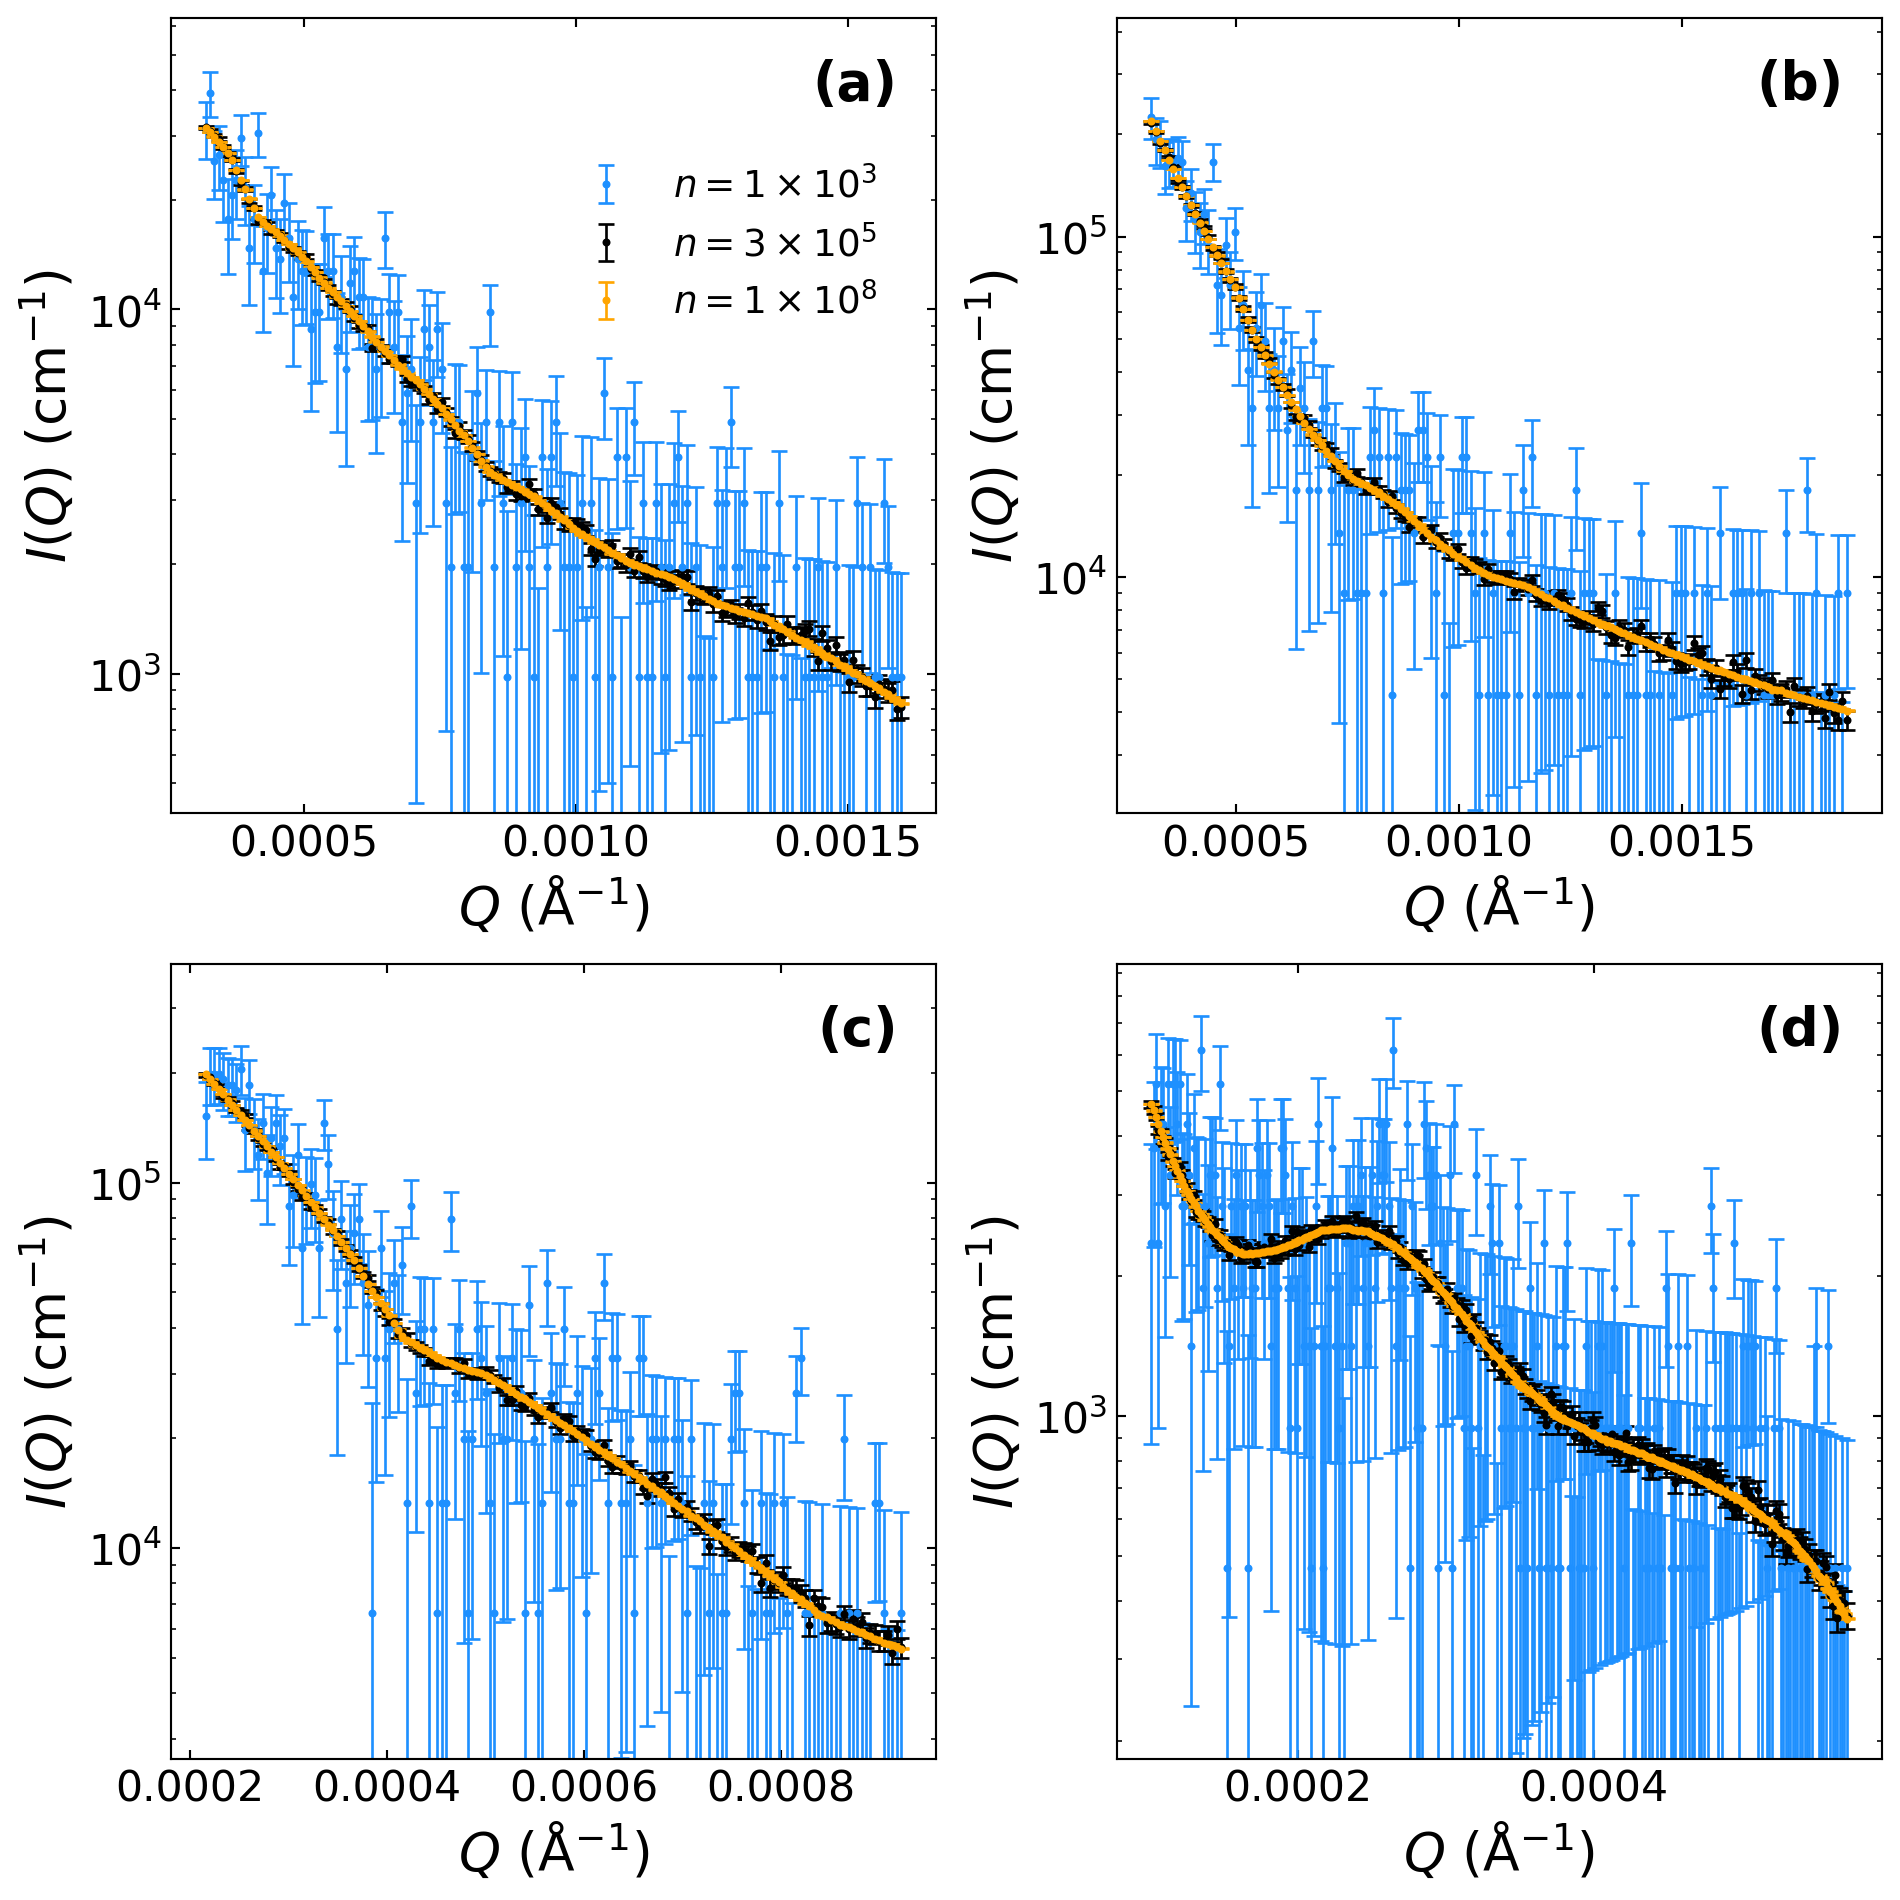

In [161]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter


filename_json_list = ["analysis_yyw.json", "analysis_tz.json", "analysis_ss.json", './binning/analysis_USANS28523.json']
label_list = ["USANS (yyw)", "USANS (tz)", "USANS (ss)", "USANS (28523)"]
fig = plt.figure(figsize=(10, 10), dpi=192)
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FF1493', '#DC143C', '#B22222']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

# Define a continuous color scale over black-green-orange-white

colors = ['#1E90FF', "black", "orange"]
cmap = LinearSegmentedColormap.from_list("black-green-orange", colors)
# cmap = plt.cm.rainbow

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    sd_syn = loaded_data["synthetic_data_list"][0]
    data = sd_syn[next(iter(sd_syn))][next(iter(sd_syn[next(iter(sd_syn))]))]
    
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    ax = fig.add_subplot(2, 2, idx + 1)
    sd_syn_best = data[str(count_list[-1])]
    
    for i_count, count in enumerate(count_list[[0,5,10]]):
        sd_syn_time = data[str(count)]
        # ax.plot(sd_syn_time['Q'], sd_syn_time['I'],'o',
        #         label=f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{np.floor(np.log10(count)).astype(int)}$', 
        #         markersize=2, 
        #         color=colors[i_count])
        ax.errorbar(sd_syn_time['Q'], sd_syn_time['I'], yerr=sd_syn_time['I_err'], 
                label=f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{np.floor(np.log10(count)).astype(int)}$', 
                fmt='o', markersize=2, elinewidth=1, capsize=3, 
                color=colors[i_count])
        # ax.fill_between(sd_syn_time['Q'], np.array(sd_syn_best['I'])-np.array(sd_syn_time['I_err']), np.array(sd_syn_best['I'])+np.array(sd_syn_time['I_err']), color=colors[i_count], alpha=0.1)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_xlim(2e-3, 2e-2)
    # ax.set_ylim(1e-1, 1e2)
    ax.set_ylim(np.min(sd_syn_time['I'])/2, np.max(sd_syn_time['I'])*2)
    # ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
    # ax.set_xticklabels(['0', '2', '4', '6'])
    ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
    ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=20)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    # ax.set_xlim(10**np.floor(np.log10(np.min(sd_syn_time['Q']))), 10**np.ceil(np.log10(np.max(sd_syn_time['Q']))))
    if idx==0:
        ax.legend(fontsize=14, frameon=False, loc=(0.5,0.6))

    ax.text(0.95, 0.95, panel_labels[idx], transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')
    
plt.tight_layout()

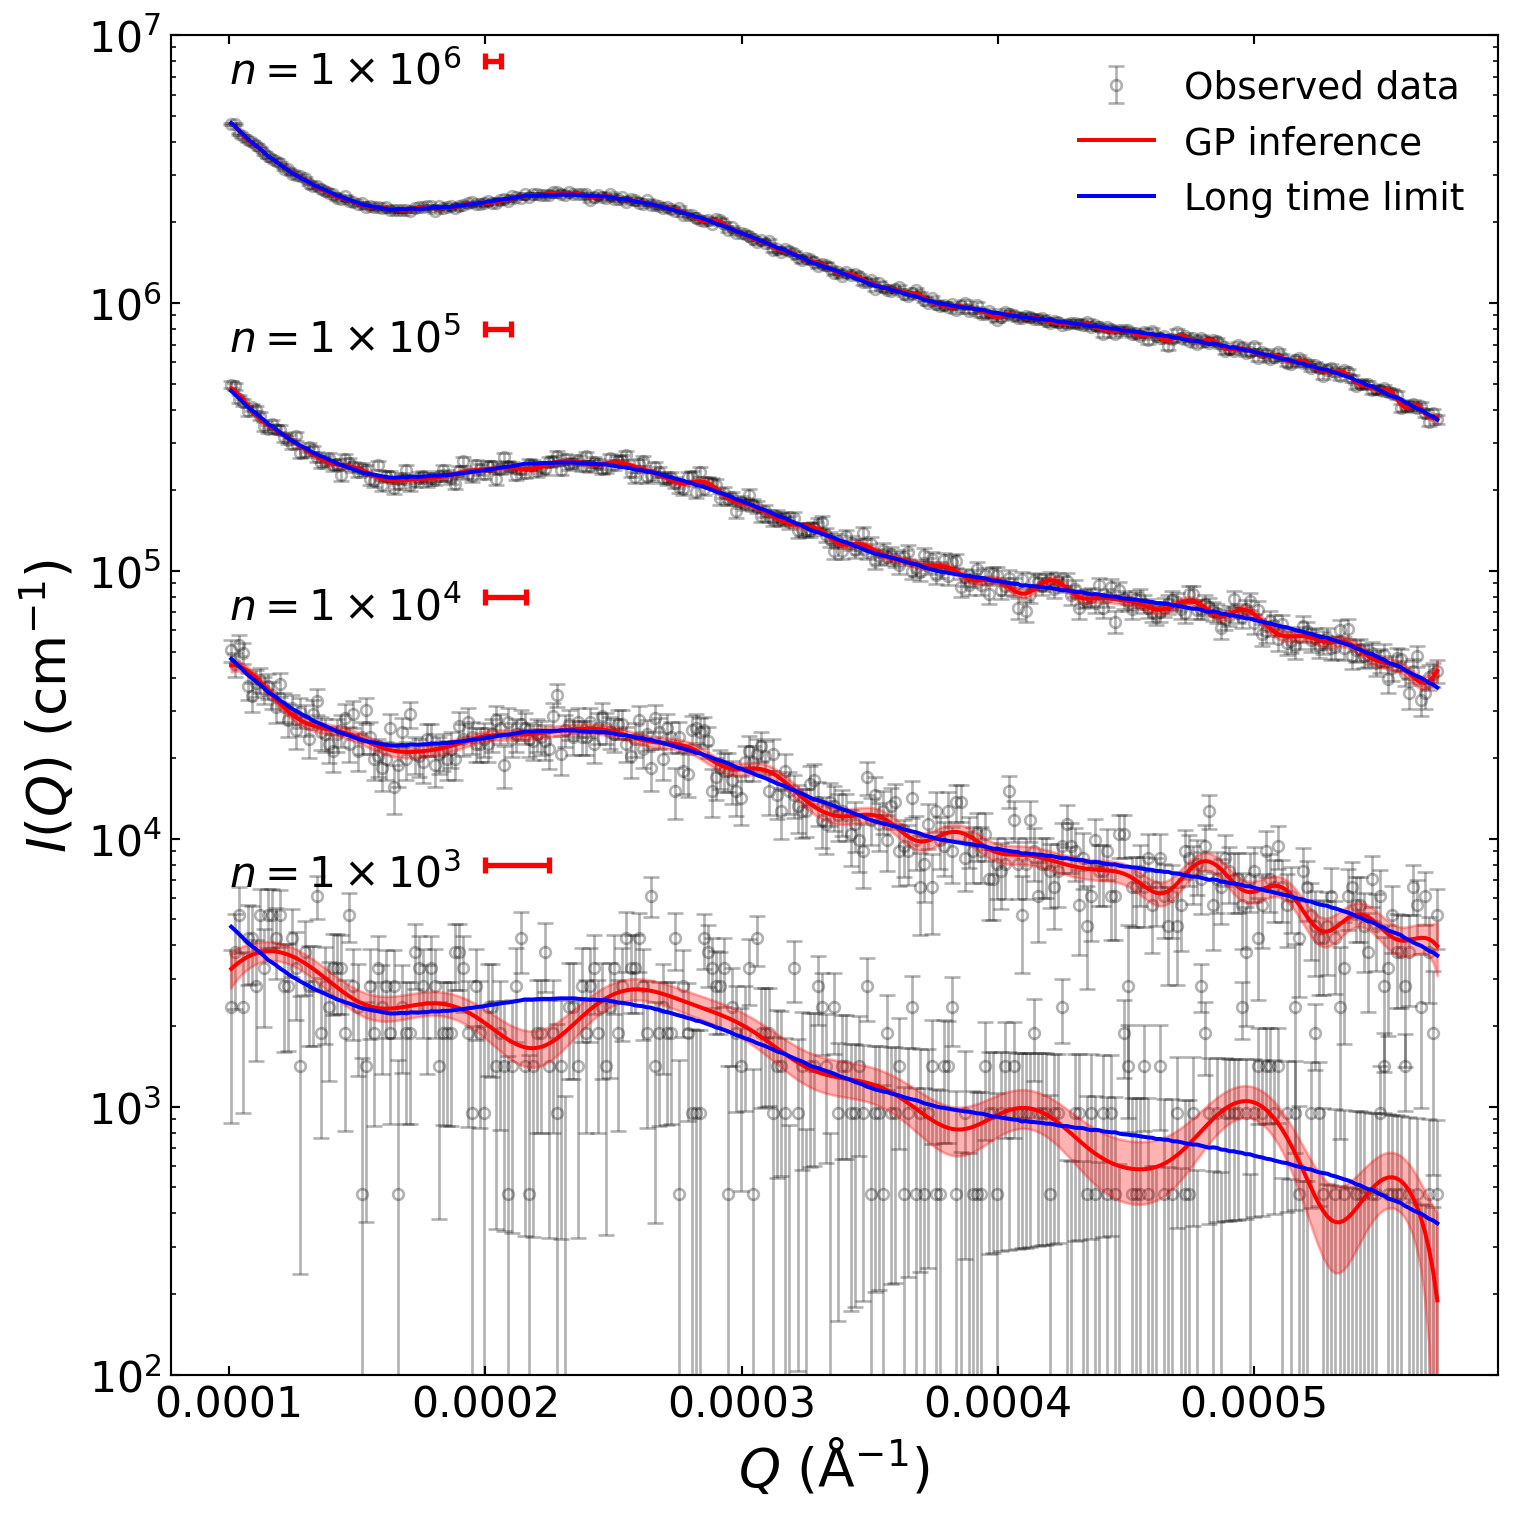

In [162]:
# side by side comparison of 28523 datasets
filename_json = './binning/analysis_USANS28523.json'
with open(filename_json, "r") as f:
    loaded_data = json.load(f)
A0_best = loaded_data["A0_best"]
beta_best = loaded_data["beta_best"]
beta_best_std = loaded_data["beta_best_std"]
gamma_best = loaded_data["gamma_best"]
gamma_best_std = loaded_data["gamma_best_std"]
pre_factor = loaded_data["pre_factor"]
count_list = np.array(loaded_data["count_list"])
mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
sd_syn = loaded_data["synthetic_data_list"][0]
data = sd_syn[next(iter(sd_syn))][next(iter(sd_syn[next(iter(sd_syn))]))]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True, dpi=192)
ax = axs

count_list_plot = count_list[[0,2,4,6]]
for idx, count in enumerate(count_list_plot):
    # ax = axs[idx]
    
    sd_syn_time = {key: np.array(value) for key, value in data[str(count)].items()}
    Q = sd_syn_time['Q']
    I = sd_syn_time['I']
    I_err = sd_syn_time['I_err']
    
    sd_syn_best = {key: np.array(value) for key, value in data[str(count_list[-1])].items()}
    I_best = sd_syn_best['I']
    
    alpha = A0_best / count
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    
    scale_shift = 10**idx
    
    I_gpr, var_I_gpr = gpr_posterior_mean(Q, I, I_err**2, length=lambda_opt, s2=float(np.var(I)) if np.isfinite(I).all() else 1.0, jitter=1e-10, var=True)
    
    labels = [None, None, None]
    if idx == 0:
        labels = ['Observed data', 'GP inference', 'Long time limit']
    
    handle1 = ax.errorbar(Q, I*scale_shift, yerr=I_err*scale_shift, fmt='o', markersize=4, elinewidth=1, capsize=3, fillstyle='none', zorder=-10, color='k', label=labels[0], alpha=0.3)
    handle2, = ax.plot(Q, I_gpr*scale_shift, '-', color='red', label=labels[1], linewidth=1.5)
    handle3, = ax.plot(Q, I_best*scale_shift, '-', color='blue', label=labels[2], linewidth=1.5)
    ax.fill_between(Q, (I_gpr - np.sqrt(var_I_gpr))*scale_shift, (I_gpr + np.sqrt(var_I_gpr))*scale_shift, color='red', alpha=0.3)
    ax.text(1e-4, 6600*scale_shift, f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{{{np.floor(np.log10(count)).astype(int)}}}$', fontsize=16, color='black')
    
    # plot a horizontal line indicating the lambda_opt
    ax.errorbar(2e-4+lambda_opt/2, 8000*scale_shift, xerr=lambda_opt/2, color='red', capsize=3, capthick=2, linewidth=2, label=r'$\lambda_\mathrm{opt}$' if idx == 0 else None)
    
    ax.set_yscale('log')
    ax.set_ylim(100, 10000*scale_shift)
    ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
    if idx == 0:
        ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=20)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    if idx == 0:
        ax.legend(handles=[handle1, handle2, handle3], labels=labels, fontsize=14, frameon=False)
    
plt.tight_layout()

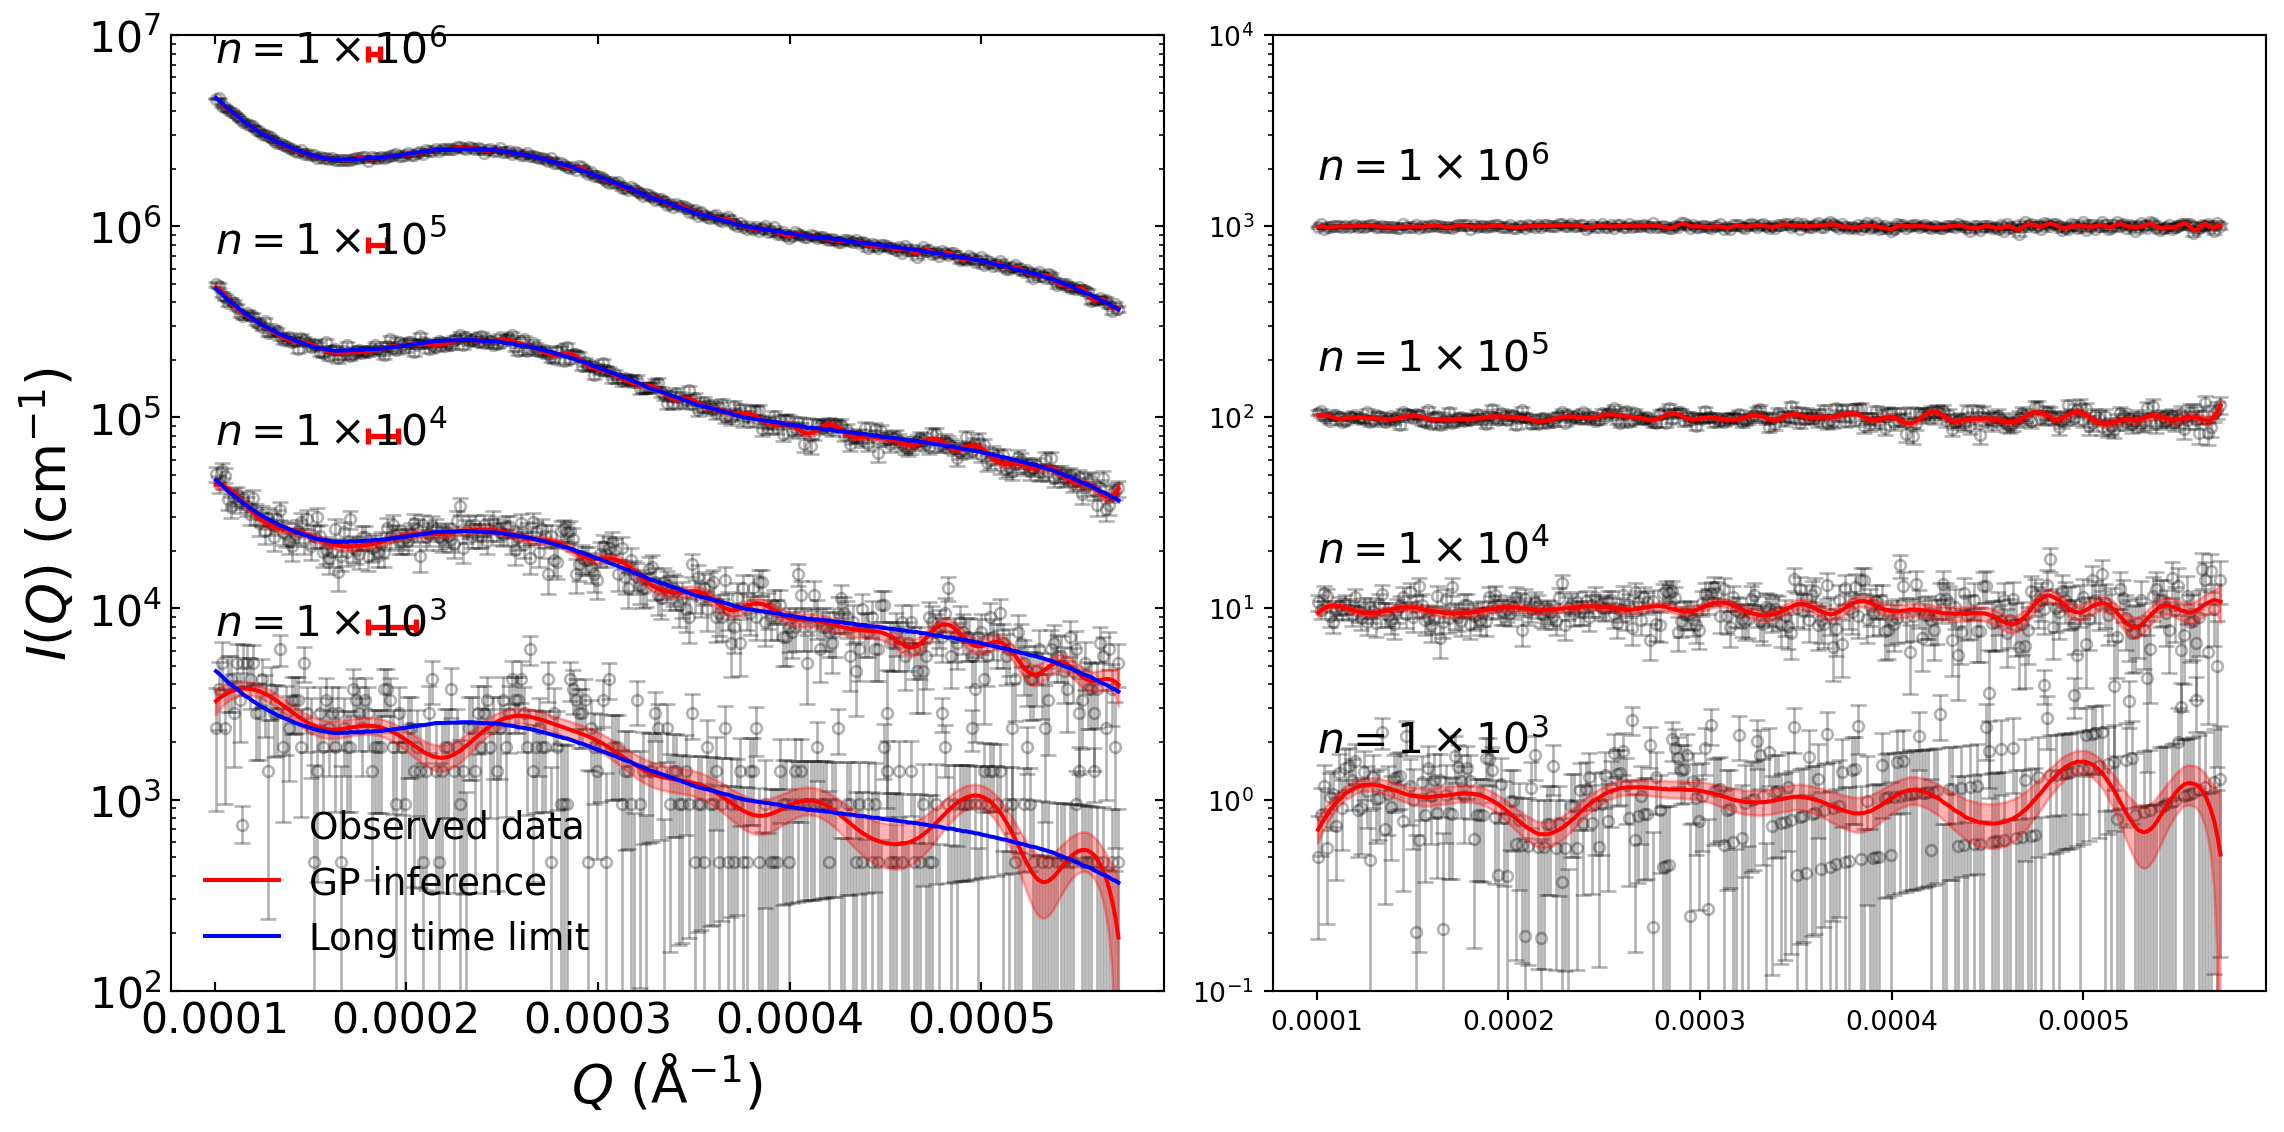

In [164]:
# side by side comparison of 28523 datasets
filename_json = './binning/analysis_USANS28523.json'
with open(filename_json, "r") as f:
    loaded_data = json.load(f)
A0_best = loaded_data["A0_best"]
beta_best = loaded_data["beta_best"]
beta_best_std = loaded_data["beta_best_std"]
gamma_best = loaded_data["gamma_best"]
gamma_best_std = loaded_data["gamma_best_std"]
pre_factor = loaded_data["pre_factor"]
count_list = np.array(loaded_data["count_list"])
mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
sd_syn = loaded_data["synthetic_data_list"][0]
data = sd_syn[next(iter(sd_syn))][next(iter(sd_syn[next(iter(sd_syn))]))]

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=192)
ax = axs[0]
ax2 = axs[1]

count_list_plot = count_list[[0,2,4,6]]
for idx, count in enumerate(count_list_plot):
    # ax = axs[idx]
    
    sd_syn_time = {key: np.array(value) for key, value in data[str(count)].items()}
    Q = sd_syn_time['Q']
    I = sd_syn_time['I']
    I_err = sd_syn_time['I_err']
    
    sd_syn_best = {key: np.array(value) for key, value in data[str(count_list[-1])].items()}
    I_best = sd_syn_best['I']
    
    alpha = A0_best / count
    lambda_opt = (alpha / (8 * np.sqrt(np.pi) * gamma_best))**(1/5)
    
    scale_shift = 10**idx
    
    I_gpr, var_I_gpr = gpr_posterior_mean(Q, I, I_err**2, length=lambda_opt, s2=float(np.var(I)) if np.isfinite(I).all() else 1.0, jitter=1e-10, var=True)
    
    labels = [None, None, None]
    if idx == 0:
        labels = ['Observed data', 'GP inference', 'Long time limit']
    
    handle1 = ax.errorbar(Q, I*scale_shift, yerr=I_err*scale_shift, fmt='o', markersize=4, elinewidth=1, capsize=3, fillstyle='none', zorder=-10, color='k', label=labels[0], alpha=0.3)
    handle2, = ax.plot(Q, I_gpr*scale_shift, '-', color='red', label=labels[1], linewidth=1.5)
    handle3, = ax.plot(Q, I_best*scale_shift, '-', color='blue', label=labels[2], linewidth=1.5)
    ax.fill_between(Q, (I_gpr - np.sqrt(var_I_gpr))*scale_shift, (I_gpr + np.sqrt(var_I_gpr))*scale_shift, color='red', alpha=0.3)
    ax.text(1e-4, 7200*scale_shift, f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{{{np.floor(np.log10(count)).astype(int)}}}$', fontsize=16, color='black')
    
    # plot a horizontal line indicating the lambda_opt
    ax.errorbar(1.8e-4+lambda_opt/2, 8000*scale_shift, xerr=lambda_opt/2, color='red', capsize=3, capthick=2, linewidth=2, label=r'$\lambda_\mathrm{opt}$' if idx == 0 else None)
    
    ax.set_yscale('log')
    ax.set_ylim(100, 10000*scale_shift)
    ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
    if idx == 0:
        ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=20)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    if idx == 0:
        ax.legend(handles=[handle1, handle2, handle3], labels=labels, fontsize=14, frameon=False)
        
    handle3 = ax2.errorbar(Q, (I/I_best)*scale_shift, yerr=(I_err/I_best)*scale_shift, fmt='o', markersize=4, elinewidth=1, capsize=3, fillstyle='none', zorder=-10, color='k', label=labels[0], alpha=0.3)
    handle4, = ax2.plot(Q, (I_gpr/I_best)*scale_shift, '-', color='red', label=labels[1], linewidth=1.5)
    # handle5, = ax2.plot(Q, (I_best/I_best)*scale_shift, '-', color='blue', label=labels[2], linewidth=1.5)
    
    ax2.fill_between(Q, ((I_gpr - np.sqrt(var_I_gpr))/I_best)*scale_shift, ((I_gpr + np.sqrt(var_I_gpr))/I_best)*scale_shift, color='red', alpha=0.3)
    ax2.text(1e-4, 1.75*scale_shift, f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{{{np.floor(np.log10(count)).astype(int)}}}$', fontsize=16, color='black')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-1, scale_shift*10)
    
plt.tight_layout()